# subset training data
This notebook contains functions to generate subsets from multiple raster sources

In [1]:
from glob import glob
import numpy as np
import xarray as xr
import rasterio as rio
import rioxarray as rxr
import geopandas as gpd
import random
import matplotlib.pyplot as plt
from rioxarray import merge
import gc

In [2]:
def open_all_data(aso_path, home_path):
    aso_fn = aso_path.split('/')[-1][:-4]
    S1_snowon_path = glob(f'{home_path}/data/S1_rtc/S1_snow-on_*_for_{aso_fn}.nc')[0]
    S1_snowoff_path = glob(f'{home_path}/data/S1_rtc/S1_snow-off_*_for_{aso_fn}.nc')[0]
    S1_snowon_mean_path = glob(f'{home_path}/data/S1_rtc_mean/S1_snow-on_*_for_{aso_fn}.nc')[0]
    S1_snowoff_mean_path = glob(f'{home_path}/data/S1_rtc_mean/S1_snow-off_*_for_{aso_fn}.nc')[0]
    S2_path = glob(f'{home_path}/data/S2/S2_*_for_{aso_fn}.nc')[0]
    fcf_path = glob(f'{home_path}/data/fcf/fcf_for_{aso_fn}.nc')[0]
    dem_path = glob(f'{home_path}/data/cop30/cop30_for_{aso_fn}.nc')[0]
    
    aso_ds = xr.open_dataset(aso_path).squeeze()
    aso_ds = aso_ds.rename({'band_data': 'aso_sd'})
    aso_ds['aso_sd'] = aso_ds['aso_sd'].where(aso_ds['aso_sd'] >= 0)
    
    S1_snowon_ds = xr.open_dataset(S1_snowon_path).squeeze()
    S1_snowon_ds = S1_snowon_ds.rename({'vv': 'snowon_vv', 'vh':'snowon_vh'})
    S1_snowon_ds = S1_snowon_ds.rio.reproject_match(aso_ds, resampling=rio.enums.Resampling.bilinear, crs=aso_ds.rio.crs)
    S1_snowoff_ds = xr.open_dataset(S1_snowoff_path).squeeze()
    S1_snowoff_ds = S1_snowoff_ds.rename({'vv': 'snowoff_vv', 'vh':'snowoff_vh'})
    S1_snowoff_ds = S1_snowoff_ds.rio.reproject_match(aso_ds, resampling=rio.enums.Resampling.bilinear, crs=aso_ds.rio.crs)
    
    S1_snowon_mean_ds = xr.open_dataset(S1_snowon_mean_path).squeeze()
    S1_snowon_mean_ds = S1_snowon_mean_ds.rename({'vv': 'snowon_vv_mean', 'vh':'snowon_vh_mean'})
    S1_snowon_mean_ds = S1_snowon_mean_ds.rio.reproject_match(aso_ds, resampling=rio.enums.Resampling.bilinear, crs=aso_ds.rio.crs)
    S1_snowoff_mean_ds = xr.open_dataset(S1_snowoff_mean_path).squeeze()
    S1_snowoff_mean_ds = S1_snowoff_mean_ds.rename({'vv': 'snowoff_vv_mean', 'vh':'snowoff_vh_mean'})
    S1_snowoff_mean_ds = S1_snowoff_mean_ds.rio.reproject_match(aso_ds, resampling=rio.enums.Resampling.bilinear, crs=aso_ds.rio.crs)
    
    S2_ds = xr.open_dataset(S2_path).squeeze()
    S2_ds = S2_ds.rio.write_crs(aso_ds.rio.crs)
    S2_ds = S2_ds.rio.reproject_match(aso_ds, resampling=rio.enums.Resampling.bilinear, crs=aso_ds.rio.crs)
    
    fcf_ds = xr.open_dataset(fcf_path).squeeze()
    fcf_ds = fcf_ds.rename({'__xarray_dataarray_variable__': 'fcf'})
    fcf_ds = fcf_ds.rio.reproject_match(aso_ds, resampling=rio.enums.Resampling.bilinear, crs=aso_ds.rio.crs)
    
    dem_ds = xr.open_dataset(dem_path).squeeze()
    dem_ds = dem_ds.rio.write_crs(aso_ds.rio.crs)
    dem_ds = dem_ds.rename({'__xarray_dataarray_variable__': 'elevation'})
    dem_ds = dem_ds.rio.reproject_match(aso_ds, resampling=rio.enums.Resampling.bilinear, crs=aso_ds.rio.crs)
    
    ds_list = [aso_ds, S1_snowon_ds, S1_snowoff_ds, S1_snowon_mean_ds, S1_snowoff_mean_ds, S2_ds, fcf_ds, dem_ds]
    
    ds = xr.merge(ds_list, compat='override', join='override').squeeze()

    return aso_fn, ds

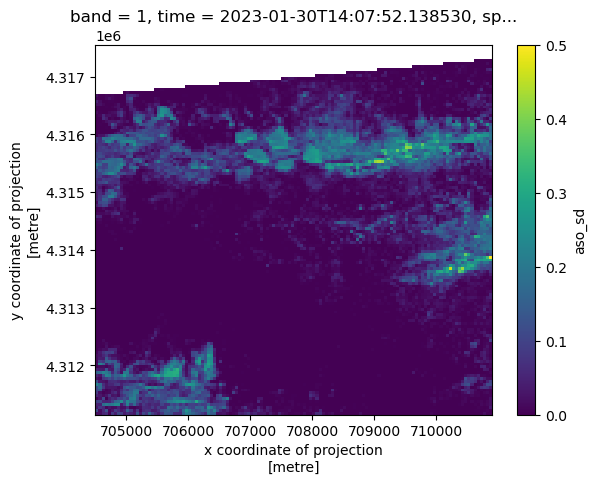

In [25]:
subset_ds.aso_sd.plot()

In [3]:
def sample_ds(ds, subset_size):
    minx = 0
    miny = 0
    maxx = len(ds.x)-subset_size
    maxy = len(ds.y)-subset_size

    sub_minx = random.randint(minx, maxx)
    sub_miny = random.randint(miny, maxy)
    subset = ds.isel(x=slice(sub_minx, sub_minx+subset_size), y=slice(sub_miny, sub_miny+subset_size))
    
    return subset

## to do:
- redo with only one set of tiles in a global projection and match projection to raster before subsetting

In [19]:
subset_size=128
avg_subs_per_pixel=3

home_path = '..'
utm_zones = ['utm10n', 'utm11n', 'utm12n', 'utm13n']
total_subsets = 0

# loop through utm zones
for utm_zone in utm_zones:
    print(f'working on {utm_zone}')
    aso_paths = glob(f'{home_path}/data/ASO/ASO_50m_SD_withS1overpass/{utm_zone}/*')
    tile_names = [f'train_aea_25km.shp', f'test_aea_25km.shp', f'val_aea_25km.shp']

    #loop through train, val, test tiles
    for tile_set in tile_names:
        # open tiles 
        print(f'working on {tile_set}')
        tiles = gpd.read_file(f'{home_path}/data/polygons/{tile_set}')

        #loop through ASO rasters
        for aso_path in aso_paths:
            # open aso raster
            raster_subsets = 0
            aso_fn, ds = open_all_data(aso_path, '..')
            print(f'working on {aso_fn}')
            # reproject tile to utm zone:
            tiles = tiles.to_crs(ds.rio.crs)

            # loop through tiles
            for tile in tiles.iterrows():
                # clip to tile extent
                try:
                    tile_ds = ds.rio.clip([tile[1].geometry], crs=ds.rio.crs, drop=True)
                except: #except if tile does not overlap interferogram
                    continue
                # set number of subsets to grab based on valid pixel count in tile 
                tile_pixel_count = np.invert(np.isnan(tile_ds.aso_sd.values)).sum()
                subset_goal = round(tile_pixel_count/(subset_size**2)*avg_subs_per_pixel)

                # pad ds to tile extent
                tile_ds = tile_ds.rio.pad_box(miny=tile[1].geometry.bounds[1],
                                              minx=tile[1].geometry.bounds[0],
                                              maxy=tile[1].geometry.bounds[3],
                                              maxx=tile[1].geometry.bounds[2])

                subset_count = 0
                while subset_count < subset_goal:
                    subset_ds = sample_ds(tile_ds, subset_size)
                    # check if subset has valid ASO pixels
                    if np.invert(np.isnan(subset_ds.aso_sd)).sum() == 0:
                        continue

                    # check for valid radar coverage 
                    elif np.sum(np.invert(np.isnan(subset_ds.aso_sd)) > np.invert(np.isnan(subset_ds.snowon_vv))) > 0:
                        continue
                    elif np.sum(np.invert(np.isnan(subset_ds.aso_sd)) > np.invert(np.isnan(subset_ds.snowon_vh))) > 0:
                        continue
                    elif np.sum(np.invert(np.isnan(subset_ds.aso_sd)) > np.invert(np.isnan(subset_ds.snowoff_vv))) > 0:
                        continue
                    elif np.sum(np.invert(np.isnan(subset_ds.aso_sd)) > np.invert(np.isnan(subset_ds.snowoff_vh))) > 0:
                        continue
                    
                    else: # save subset
                        # create map of gaps
                        ds['gap_map'] = np.multiply(np.isnan(subset_ds.aso_sd), 1)
                        # fill nans with 0 
                        subset_ds = subset_ds.fillna(0)
                        subset_count+=1
                        total_subsets+=1
                        raster_subsets+=1
                        # subset_ds.to_netcdf(f'{home_path}/data/subsets/{tile_set.split("_")[0]}_subsetsv0/{aso_fn}_tile{int(tile[1].id)}_s{subset_count}.nc')
                        # subset_ds.aso_sd.rio.to_raster(f'{home_path}/data/subsets_tif/{tile_set.split("_")[0]}_subsetsv0/{aso_fn}_tile{int(tile[1].id)}_s{subset_count}.tif')
                        
            print(f'total subsets from {aso_fn}: {raster_subsets}')
            gc.collect()

working on utm10n
working on train_aea_25km.shp
working on ASO_50M_SD_American_20230131_clean
done reprojecting
done clipping
done padding
done clipping
done padding
done clipping
done padding
done clipping
done padding
done clipping
done padding



KeyboardInterrupt

